In [382]:
import pandas as pd
import numpy as np
import sys
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from scipy import stats
import math

In [383]:
df_calls = pd.read_csv('../cotton/data/df_cotton_on_call_contracts.csv').rename(columns={'futures_contract':'contract_code'})
df_prices = pd.read_csv('../cotton/data/df_cotton_prices.csv').rename(columns={'a_index':'price'})
df_futures = pd.read_csv('../cotton/data/df_cotton_futures.csv')
df_spot_price = df_futures[df_futures.contract_code == 'CTY00']

In [384]:
df_spot_price.sort_values('date')

,id,date,contract_code,open,high,low,close,open_interest,volume
118756,118757,2022-03-28,CTY00,140.07,140.07,140.07,140.07,NaN,NaN
118755,118756,2022-03-29,CTY00,137.81,137.81,137.81,137.81,NaN,NaN
118754,118755,2022-03-30,CTY00,140.84,140.84,140.84,140.84,NaN,NaN
118753,118754,2022-03-31,CTY00,136.69,136.69,136.69,136.69,NaN,NaN
118752,118753,2022-04-01,CTY00,135.55,135.55,135.55,135.55,NaN,NaN
...,...,...,...,...,...,...,...,...,...
118761,118762,2024-07-02,CTY00,65.50,65.50,65.50,65.50,NaN,NaN
118760,118761,2024-07-03,CTY00,64.85,64.85,64.85,64.85,NaN,NaN
118759,118760,2024-07-05,CTY00,63.48,63.48,63.48,63.48,NaN,NaN
118758,118759,2024-07-08,CTY00,63.49,63.49,63.49,63.49,NaN,NaN


In [106]:
df_calls.merge(df_futures, on='contract_code'

,id,date,futures_contract,month,unfixed_sale,unfixed_purchase,report_week
0,1,2004-12-03,CTZ04,December 2004,82,326,49
1,2,2004-12-03,CTH05,March 2005,9232,3203,49
2,3,2004-12-03,CTK05,May 2005,6879,1538,49
3,4,2004-12-03,CTN05,July 2005,14553,634,49
4,5,2004-12-03,CTV05,October 2005,2574,141,49
...,...,...,...,...,...,...,...
9713,12876,2020-01-30,CTV20,October 2020,0,0,4
9714,12877,2020-01-30,CTZ20,December 2020,17466,18378,4
9715,12878,2020-01-30,CTH21,March 2021,6574,1063,4
9716,12879,2020-01-30,CTK21,May 2021,2801,191,4


In [107]:
df_futures.pivot_table(index='date', 

,id,date,contract_code,open,high,low,close,open_interest,volume
0,1,1994-01-03,CCH94,NaN,1166.00,1137.00,1165.00,34816.0,4808.0
1,2,1994-01-03,CCK94,NaN,1199.00,1171.00,1197.00,14122.0,835.0
2,3,1994-01-03,CCN94,NaN,1230.00,1198.00,1229.00,9576.0,378.0
3,4,1994-01-03,CCU94,NaN,1252.00,1231.00,1251.00,6292.0,77.0
4,5,1994-01-03,CCZ94,NaN,1270.00,1256.00,1278.00,6408.0,0.0
...,...,...,...,...,...,...,...,...,...
119032,119033,2024-05-27,CTK25,NaN,NaN,NaN,80.81,4897.0,0.0
119033,119034,2024-05-28,CTK25,NaN,81.95,80.59,81.86,4904.0,1551.0
119034,119035,2024-05-29,CTK25,NaN,81.77,80.61,80.98,4984.0,1829.0
119035,119036,2024-05-30,CTK25,NaN,81.18,78.72,79.79,5065.0,181.0


<Axes: xlabel='date'>

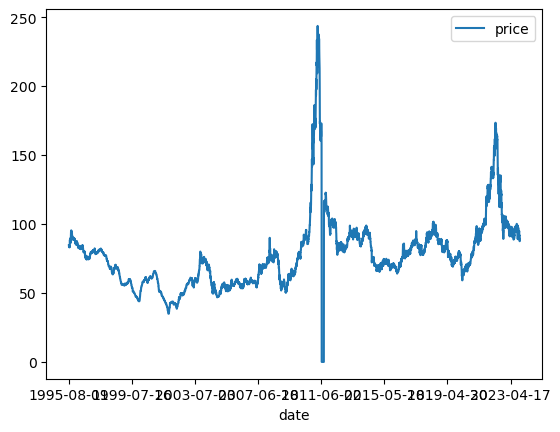

In [3]:
df_prices.plot(x='date', y='price')

In [4]:
# Overwrite prices from 30 days prior to the date at which there is an error in the data, up till the end of the problem.
# Need to overwrite with np.nan rather than dropping the rows so that the time integrigty of the outcome variables during 
# these is maintained. Otherwise prices from beyond the period will be brought forward into the outcomes prior to the period
df_prices['price'] = np.where((df_prices.date < '2011-05-10') | (df_prices.date > '2011-07-29'), df_prices['price'], np.nan)

<Axes: xlabel='date'>

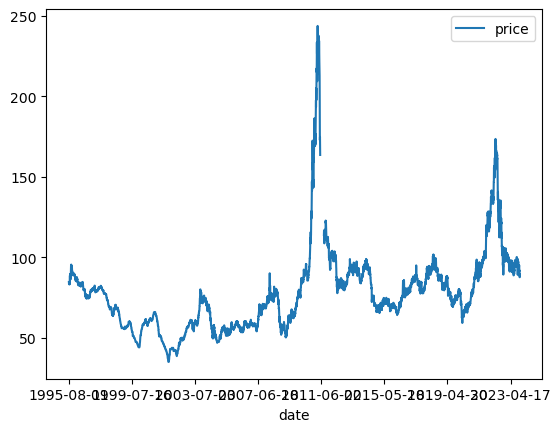

In [5]:
df_prices.plot(x='date', y='price')

In [26]:
def add_cyclical_features(df, datetime_var, period, start_num=0):
    
    values = 2 * np.pi * (df[datetime_var] - start_num) / period
    kwargs = {f'sin_{datetime_var}': lambda x: np.sin(values),
              f'cos_{datetime_var}': lambda x: np.cos(values)}
    
    return df.assign(**kwargs)

In [441]:
class OnCallPrep:
    
    def __init__(self, df_calls):
        
        self.df_calls = df_calls.copy()
        
        self._create_misc_vars()

    def _create_misc_vars(self):
        
        self.df_calls['unfixed_net'] = self.df_calls['unfixed_sale'] - self.df_calls['unfixed_purchase']
        self.df_calls['unfixed_net_prop'] = self.df_calls['unfixed_sale'] / self.df_calls['unfixed_purchase']
        self.df_calls['report_month'] = pd.to_datetime(self.df_calls['date']).dt.month
        self.df_calls['report_year'] = pd.to_datetime(self.df_calls['date']).dt.isocalendar().year
        self.df_calls['futures_datetime'] = pd.to_datetime(self.df_calls['month'])
        self.df_calls['futures_'] = pd.to_datetime(self.df_calls['month']).dt.isocalendar().year
        self.df_calls['futures_month'] = pd.to_datetime(self.df_calls['month']).dt.month
        self.df_calls['futures_year'] = pd.to_datetime(self.df_calls['month']).dt.isocalendar().year

        self.df_calls['futures_month_ranked'] = self.df_calls.groupby('date')['futures_datetime'].rank(method='dense')
        
        self.df_calls = self._define_seasons(self.df_calls)
        
        # self.df_calls['season'] = np.where(self.df_calls['report_year'] == self.df_calls['futures_year'], 'season1',
        #                np.where(self.df_calls['report_year'] + 1 == self.df_calls['futures_year'], 'season2',
        #                   np.where(self.df_calls['report_year'] + 2 == self.df_calls['futures_year'], 'season3', 'season_OTHER')))

#         self.df_calls = self.df_calls[self.df_calls.season.isin(['season1', 'season2'])].copy()
        
    def _define_seasons(self, df):
        
        df['season'] = np.where(df['report_month'] <= 7,
                            np.where(df['futures_month'] < 12,  
                                    np.where(df['report_year'] == df['futures_year'], 'season1',  
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season3', 'seasonOTHER'))),
                                np.where(df['report_year'] == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season3', 'seasonOTHER'))),
                            np.where(df['futures_month'] < 12,  
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season1',  
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 3 == df['futures_year'], 'season3', 'seasonOTHER'))),
                                np.where(df['report_year'] == df['futures_year'], 'season1', 
                                    np.where(df['report_year'] + 1 == df['futures_year'], 'season2', 
                                    np.where(df['report_year'] + 2 == df['futures_year'], 'season3', 'seasonOTHER')))))                                     
                                             
        return df

    def _create_call_features(self, df_calls, var):

        df_call_months = df_calls.pivot_table(index=['date', 'report_week', 'report_month'], columns='futures_month_ranked', 
                                                  values=var, aggfunc='first').reset_index()
        df_call_months = df_call_months.rename(columns={x: f'{var}_calls_month_' + str(int(x)) for x in df_call_months.columns if x not in ['date', 'report_week', 'report_month']})

        df_yearweek_total_calls = df_calls.groupby(['date', 'report_week', 'report_month'])[var].sum()\
                                          .reset_index().rename(columns={var:f'{var}_total_calls'})
        
        df_yearweek_total_calls_s1 = df_calls[df_calls.season=='season1'].groupby(['date', 'report_week', 'report_month'])[var].sum()\
                                          .reset_index().rename(columns={var:f'{var}_total_calls_season1'})
        df_yearweek_total_calls_s2 = df_calls[df_calls.season=='season2'].groupby(['date', 'report_week', 'report_month'])[var].sum()\
                                          .reset_index().rename(columns={var:f'{var}_total_calls_season2'})
        
        df_features = df_call_months.merge(df_yearweek_total_calls, on=['date', 'report_week', 'report_month'], how='left')\
                                    .merge(df_yearweek_total_calls_s1, on=['date', 'report_week', 'report_month'], how='left')\
                                    .merge(df_yearweek_total_calls_s2, on=['date', 'report_week', 'report_month'], how='left')
        
        ignore_cols = ['date', 'report_week', 'report_month']
        ignore_cols = ignore_cols + [x for x in df_features.columns if 'month_7' in x or 'month_8' in x]
        for feat in [col for col in df_features.columns if col not in ignore_cols]:
            for n_weeks in [1, 2, 4, 8, 12]:
                # df_features[feat + f'_pct_change_{n_weeks}week'] = (df_features[feat] / df_features[feat].shift(n_weeks)) - 1
                
                # Changed definition to prevent Inf values when shifted column has value 0 (which I think will be more likely than current week for the most relevant variables) 
                # New feature is bound between (-Inf, 1]. 
                # 1 represents when previous week has value 0 and current week has value > 0.
                # If previous week has a value > current week, the feature will scale down to minus infinity
                df_features[feat + f'_pct_change_{n_weeks}week'] = 1 - (df_features[feat].shift(n_weeks) / df_features[feat])
                
                min_value = df_features[feat + f'_pct_change_{n_weeks}week'].replace([-np.inf], np.nan).min()
                df_features[feat + f'_pct_change_{n_weeks}week'] = df_features[feat + f'_pct_change_{n_weeks}week'].replace([-np.inf], min_value)
 
                max_value = df_features[feat + f'_pct_change_{n_weeks}week'].replace([np.inf], np.nan).max()
                df_features[feat + f'_pct_change_{n_weeks}week'] = df_features[feat + f'_pct_change_{n_weeks}week'].replace([np.inf], max_value)
        
        return df_features
    
    def create_features(self):
        
        df_features_sale = self._create_call_features(self.df_calls, 'unfixed_sale')
        df_features_purchase = self._create_call_features(self.df_calls, 'unfixed_purchase')
        df_features_net = self._create_call_features(self.df_calls, 'unfixed_net')
        df_features_net_prop = self._create_call_features(self.df_calls, 'unfixed_net_prop')
        
        df_features = df_features_sale.merge(df_features_purchase, on=['date', 'report_week', 'report_month'], how='outer')\
                                      .merge(df_features_net, on=['date', 'report_week', 'report_month'], how='outer')\
                                      .merge(df_features_net_prop, on=['date', 'report_week', 'report_month'], how='outer')
        

        self.df_features = add_cyclical_features(df_features, 'report_week', 52, 1)

    def build_outcomes(self, df_in, var, datetime_var, n_forward_looks = [1, 2, 3, 5, 10]):

        df = df_in[[datetime_var, var]] .copy()
        for n in n_forward_looks:
            df[f'max_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=0)[var]
                    .max()
                    .iloc[::-1])

            df[f'mean_{n}_forward'] = (df.iloc[::-1]
                    .rolling(n, on=datetime_var, min_periods=0)[var]
                    .mean()
                    .iloc[::-1])

            df[f'value_delta_mean_{n}_forward'] = df[f'mean_{n}_forward'] - df[var]
            df[f'value_delta_max_{n}_forward'] = df[f'max_{n}_forward'] - df[var]

            df[f'pct_delta_mean_{n}_forward'] = (df[f'mean_{n}_forward'] / df[var]) - 1
            df[f'pct_delta_max_{n}_forward'] = (df[f'max_{n}_forward'] / df[var]) - 1   

            df[f'binary_mean_rise_{n}_forward'] = np.where(df[f'pct_delta_mean_{n}_forward'] > 0, 1, 0)
            df[f'binary_max_rise_{n}_forward'] = np.where(df[f'pct_delta_max_{n}_forward'] > 0, 1, 0)

            # These values are highly correlated with calls variables, because they are higly correlted with the price at the given time.
            # The high correlation, along with price itself, only tells us that there are many unfixed purchases when prices are low and
            # fewer when prices are high. If we were to use the on-call variables which correlate highly with these, we would just be learning 
            # that when there are high unfixed calls, the price is likely to be low, rather than learning whther the price is likely to
            # increase from here
            df = df.drop(columns=[f'max_{n}_forward', f'mean_{n}_forward'])

        return df.drop(columns=var)
    
    def merge_outcomes(self, df_prices, n_forward_looks):
        
        self.df_outcomes = self.build_outcomes(df_prices, var='price', datetime_var='date', n_forward_looks=n_forward_looks)
        
        self.df_mset = self.df_features.merge(self.df_outcomes, on='date', how='left')
        
    def upload(self, filepath):
        
        self.df_mset.to_csv(filepath, index=False)

In [442]:
prep = OnCallPrep(df_calls)
prep.create_features()
prep.merge_outcomes(df_prices, n_forward_looks=[30])
# prep.upload('../cotton/data/df_on_call_modelset_old.csv')
df_mset = prep.df_mset.copy()

In [443]:
df_mset.isnull().sum().sort_values()

date                                                0
unfixed_purchase_calls_month_3                      0
unfixed_purchase_calls_month_4                      0
unfixed_purchase_calls_month_5                      0
unfixed_purchase_calls_month_6                      0
                                                 ... 
unfixed_net_prop_total_calls_pct_change_8week     771
unfixed_net_prop_total_calls_pct_change_4week     775
unfixed_net_prop_total_calls_pct_change_1week     775
unfixed_net_prop_total_calls_pct_change_2week     778
unfixed_net_prop_total_calls_pct_change_12week    789
Length: 235, dtype: int64

In [391]:
df_mset[df_mset.unfixed_net_prop_total_calls_pct_change_12week.isnull()][['date', 'unfixed_net_prop_total_calls', 'unfixed_net_prop_total_calls_pct_change_12week']]

,date,prop_calls_month_1,prop_calls_month_2,prop_calls_month_3,prop_calls_month_4,prop_calls_month_5,prop_calls_month_6,prop_calls_month_7,prop_calls_month_8,prop_total_calls,prop_total_calls_pct_change_12week
0,2001-02-02,0.399167,0.521431,0.859034,0.773306,0.692481,0.648531,0.995505,1.0,5.889455,NaN
1,2001-02-09,0.411510,0.454246,0.834987,0.769813,0.687545,0.659206,0.990957,1.0,5.808264,NaN
2,2001-02-16,0.332628,0.425401,0.841433,0.764414,0.705165,0.679122,1.000000,1.0,5.748162,NaN
3,2001-02-23,0.102334,0.330281,0.825665,0.750818,0.714866,0.691320,0.996348,1.0,5.411631,NaN
4,2001-03-02,1.000000,0.308096,0.831787,0.731039,0.719977,0.706124,0.996681,1.0,6.293703,NaN
5,2001-03-09,0.500000,0.315205,0.831599,0.730278,0.712096,0.711150,0.996755,1.0,5.797084,NaN
6,2001-03-16,0.500000,0.282092,0.804719,0.694479,0.688171,0.713837,1.000000,1.0,5.683298,NaN
7,2001-03-23,0.721714,1.000000,1.000000,1.000000,0.793904,1.000000,1.000000,1.0,7.515618,NaN
8,2001-03-30,0.719173,1.000000,1.000000,1.000000,0.803324,1.000000,1.000000,1.0,7.522498,NaN
9,2001-04-06,0.740398,1.000000,1.000000,1.000000,0.830751,1.000000,1.000000,1.0,7.571148,NaN


In [213]:
df_calls.shape

(9718, 7)

In [157]:
prep.df_calls.shape

(9718, 16)

In [142]:
df = prep.df_calls[['date', 'month', 'season', 'unfixed_sale']].sort_values(['date', 'month']).reset_index(drop=True)

df[df.season == 'seasonOTHER'].month.unique()

array(['October 2002', 'October 2003', 'October 2004', 'October 2005',
       'October 2006', 'October 2007', 'October 2008', 'October 2009',
       'October 2010', 'October 2011', 'October 2012', 'October 2013',
       'October 2014', 'October 2015', 'October 2016', 'October 2017',
       'October 2018', 'October 2019', 'October 2020', 'October 2021',
       'October 2022', 'October 2023'], dtype=object)

In [79]:
df_mset = df_mset[df_mset['binary_mean_rise_30_forward'].notnull()]

In [81]:
# df_mset.isnull().sum().sort_values().reset_index().loc[100:]

In [121]:
df_mset[['date', 'report_week'] + [x for x in df_mset.columns if 'calls_month' in x and 'pct' not in x]]

,date,report_week,unfixed_sale_calls_month_1,unfixed_sale_calls_month_2,unfixed_sale_calls_month_3,unfixed_sale_calls_month_4,unfixed_sale_calls_month_5,unfixed_sale_calls_month_6,unfixed_sale_calls_month_7,unfixed_sale_calls_month_8,unfixed_purchase_calls_month_1,unfixed_purchase_calls_month_2,unfixed_purchase_calls_month_3,unfixed_purchase_calls_month_4,unfixed_purchase_calls_month_5,unfixed_purchase_calls_month_6,unfixed_purchase_calls_month_7,unfixed_purchase_calls_month_8
0,2001-02-02,5,2108.0,6764.0,16222.0,1518.0,3684.0,9226.0,3322.0,5062.0,3173.0,6208.0,2662.0,445.0,1636.0,5000.0,15.0,0.0
1,2001-02-09,6,1616.0,5927.0,15570.0,1525.0,3809.0,9778.0,3397.0,5488.0,2311.0,7121.0,3077.0,456.0,1731.0,5055.0,31.0,0.0
2,2001-02-16,7,943.0,5252.0,15150.0,1538.0,4451.0,10614.0,3777.0,6339.0,1892.0,7094.0,2855.0,474.0,1861.0,5015.0,0.0,0.0
3,2001-02-23,8,57.0,3967.0,13853.0,1377.0,4924.0,11198.0,4092.0,6779.0,500.0,8044.0,2925.0,457.0,1964.0,5000.0,15.0,0.0
4,2001-03-02,9,6.0,3113.0,12639.0,1253.0,4934.0,12014.0,4504.0,7528.0,0.0,6991.0,2556.0,461.0,1919.0,5000.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,2024-05-10,19,0.0,16052.0,0.0,22100.0,6638.0,2899.0,2151.0,687.0,0.0,6520.0,0.0,40355.0,5465.0,995.0,48.0,23809.0
1211,2024-05-17,20,13769.0,0.0,23663.0,6690.0,2894.0,2614.0,828.0,NaN,6530.0,0.0,40663.0,5481.0,995.0,48.0,24030.0,NaN
1212,2024-05-24,21,10438.0,0.0,25272.0,7305.0,4015.0,2632.0,854.0,NaN,5956.0,0.0,41084.0,5660.0,995.0,48.0,26956.0,NaN
1213,2024-05-31,22,9376.0,0.0,27475.0,7557.0,4338.0,3026.0,955.0,NaN,5573.0,0.0,41588.0,5950.0,1195.0,48.0,26968.0,NaN


In [444]:
outcome_vars = [x for x in prep.df_outcomes if x not in ['date', 'price']]
correlation_vars = [x for x in df_mset.columns if x not in ['date', 'report_month']]
feat_vars = [x for x in correlation_vars if x not in outcome_vars]
df_corr = df_mset[correlation_vars].corr()
df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values('value_delta_mean_30_forward')
df_corr.style.background_gradient(cmap='coolwarm')

,value_delta_mean_30_forward,value_delta_max_30_forward,pct_delta_mean_30_forward,pct_delta_max_30_forward,binary_mean_rise_30_forward,binary_max_rise_30_forward
unfixed_net_prop_calls_month_2_pct_change_4week,-0.170384,-0.271460,0.019963,0.032719,-0.000118,0.059857
unfixed_net_prop_calls_month_3_pct_change_12week,-0.159619,-0.243658,0.034315,0.064359,0.007923,0.078651
unfixed_net_prop_calls_month_2_pct_change_8week,-0.126528,-0.125738,0.057507,0.076884,0.065927,0.112379
unfixed_purchase_total_calls_season1_pct_change_2week,-0.120598,-0.110251,0.000947,0.020756,-0.003382,-0.022772
unfixed_sale_calls_month_6_pct_change_2week,-0.112639,-0.106157,0.046181,0.065159,0.046779,0.044958
unfixed_purchase_calls_month_1_pct_change_8week,-0.098986,-0.121212,-0.042876,-0.045741,-0.029815,-0.103708
unfixed_net_prop_calls_month_2_pct_change_2week,-0.097259,-0.177394,-0.003331,0.020860,-0.030271,0.054899
unfixed_net_prop_calls_month_6_pct_change_2week,-0.087931,-0.057846,0.005203,0.035539,0.035461,0.014501
sin_report_week,-0.087717,-0.032729,-0.097126,-0.074522,-0.061430,-0.043994
unfixed_sale_calls_month_6_pct_change_4week,-0.083615,-0.064879,0.032040,0.068319,0.033638,0.039636


<Axes: xlabel='unfixed_net_prop_total_calls_season1', ylabel='value_delta_max_30_forward'>

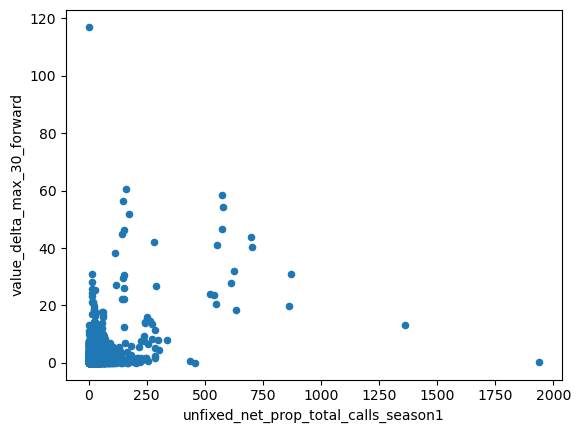

In [226]:
df_mset.plot(kind='scatter', x='unfixed_net_prop_total_calls_season1', y='value_delta_max_30_forward')

In [90]:
var = 'unfixed_purchase_calls_month_2_pct_change_4week'
df_stat = df_mset[(df_mset[var].notnull())]
stats.pointbiserialr(df_stat[var], df_stat['binary_mean_rise_30_forward'])

SignificanceResult(statistic=0.07216328872860983, pvalue=0.016875020186839736)

In [221]:
df_corr_top

,index,value_delta_mean_30_forward
0,unfixed_purchase_total_calls_season1,-0.461605
1,unfixed_purchase_calls_month_2,-0.399632
2,unfixed_purchase_total_calls,-0.270182
3,unfixed_net_prop_total_calls_season1,0.508085
4,unfixed_net_prop_calls_month_2,0.529571
5,unfixed_net_prop_calls_month_4,0.613371


In [304]:
# class Correlations:
    
#     def monthly_correlations(self, df_mset, outcome):
        
#         correlations = []

#         for month in df_mset['report_month'].unique():
#             df_corr = self.get_month_correlations(month, outcome)
#             correlations.append(df_corr)
            
#         df_monthly_corrs = pd.concat(correlations)
        
#         return df_monthly_corrs
            
#     def get_month_correlations(df_mset, month, outcome, top_n=5):
            
#         df = df_mset[df_mset['report_month'] == month]
#         df_corr = df[correlation_vars].corr()
#         df_corr = df_corr.drop(outcome_vars, axis=0)[outcome_vars].sort_values(outcome)
#         df_corr_top = pd.concat([df_corr[[outcome]].iloc[0:top_n], df_corr[[outcome]].iloc[-top_n:]], axis=0)\
#                         .reset_index().rename(columns={'index':'feat'})
#         for i, row in df_corr_top.iterrows():
#             feat = row['feat']
#             null_prop = df[df[feat].isnull()].shape[0] / df.shape[0]
#             df_corr_top.loc[i, 'null_prop'] = null_prop
#         df_corr_top['report_month'] = month
        
#         return df_corr_top, df
    
#     def plot(df_mset, month, outcome, top_n=6, n_per_row=3, figsize=(15, 7)):
        
#         df_corr, df_month = Correlations.get_month_correlations(df_mset, month, outcome, top_n=top_n)
        
#         n_rows = math.ceil(top_n / n_per_row)
#         _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)
        
#         for feat, ax in zip(df_corr['feat'].values, axs.flatten()):
#             ax.plot(x=df_month['feat'], y=df_month[outcome], kind='scatter') 
#             ax.set_title(feat + ' month ' + str(month))  
            
            
# outcome = 'value_delta_mean_30_forward'            
# Correlations.plot(df_mset[feat_vars + [outcome]], 1, outcome, top_n=6, n_per_row=3, figsize=(15, 7))

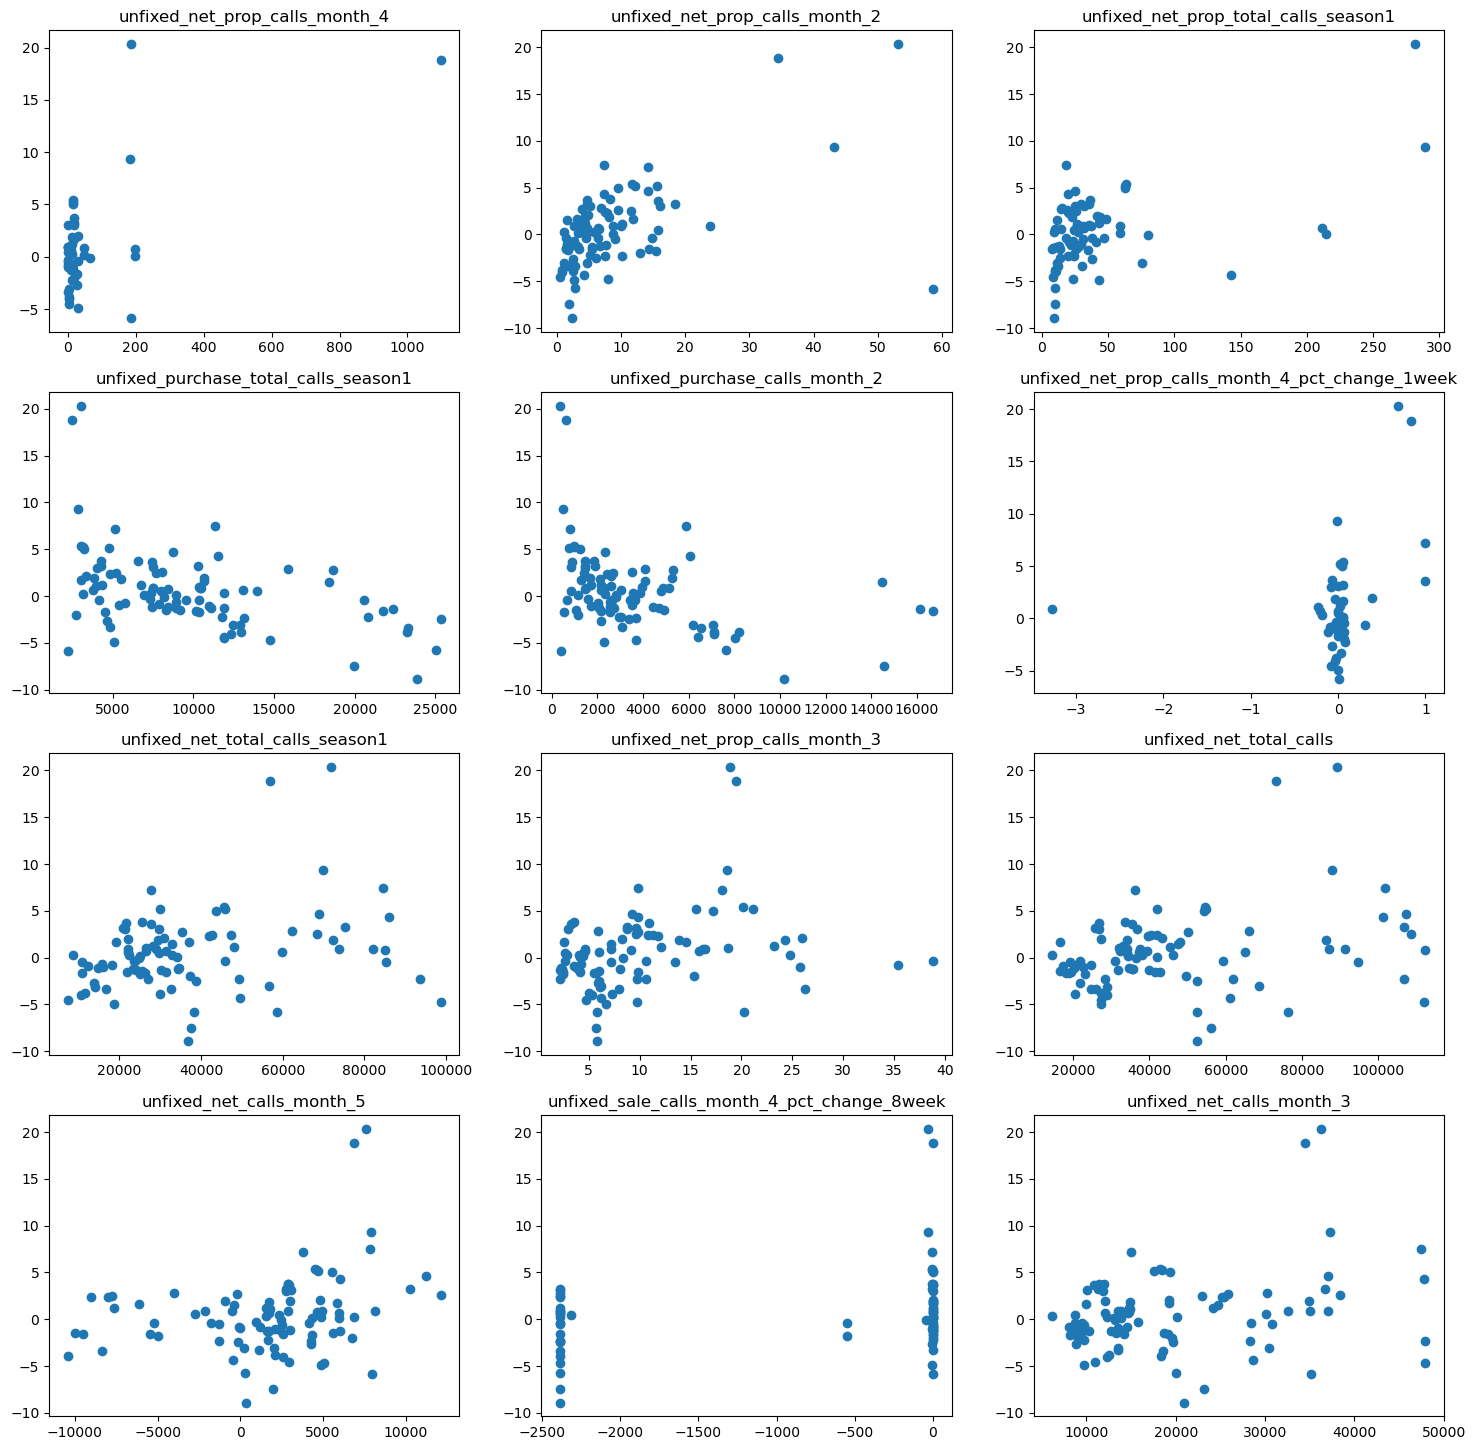

In [334]:
class Correlations:
    
    def __init__(self, df_mset, feat_vars, outcome):
        
        self.df_mset = df_mset
        self.feat_vars = feat_vars
        self.outcome = outcome
        
        # outcome_vars = [x for x in prep.df_outcomes if x not in ['date', 'price']]
        # correlation_vars = [x for x in df_mset.columns if x not in ['date', 'report_month']]
        # feat_vars = [x for x in correlation_vars if x not in outcome_vars]
        
        self.correlation_vars = feat_vars + [outcome]
        
        self.df_corr = self.df_mset[self.correlation_vars].corr()
        self.df_corr = self.df_corr.drop([self.outcome], axis=0)[[self.outcome]].sort_values(self.outcome)
        self.df_corr.style.background_gradient(cmap='coolwarm')
    
    def monthly_correlations(self):
        
        correlations = []

        for month in self.df_mset['report_month'].unique():
            df_corr = self.get_month_correlations(month, outcome)
            correlations.append(df_corr)
            
        self.df_monthly_corrs = pd.concat(correlations)
            
    def get_month_correlations(self, month, top_n=5):
            
        df = self.df_mset[self.df_mset['report_month'] == month]
        
        df_corr = df[self.correlation_vars].corr()
        df_corr = df_corr.drop(self.outcome, axis=0)[self.outcome]\
                         .reset_index().rename(columns={'index':'feat'})
        
        df_corr['abs_corr'] = abs(df_corr[self.outcome])
        df_corr = df_corr.sort_values('abs_corr', ascending=False)
        df_corr_top = df_corr.iloc[0:top_n].copy()
        
        # df_corr_top = pd.concat([df_corr[[self.outcome_vars]].iloc[0:top_n], df_corr[[outcome]].iloc[-top_n:]], axis=0)\
        #                 .reset_index().rename(columns={'index':'feat'})
        for i, row in df_corr_top.iterrows():
            feat = row['feat']
            null_prop = df[df[feat].isnull()].shape[0] / df.shape[0]
            df_corr_top.loc[i, 'null_prop'] = null_prop
        df_corr_top['report_month'] = month
        
        # df_corr_low_nulls = df_corr[df_corr.null_prop >= min_null_prop].copy()
        # df_corr_low_nulls = df_corr_low_nulls.sort_values('abs_corr', ascending=False).reset_index()
        # df_corr_top = df_corr_low_nulls.iloc[0:top_n].copy()
        
        return df_corr_top, df
    
    def plot_correlations(self, month, top_n=6, n_per_row=3, figsize=(15, 7)):
        
        df_corr, df_month = self.get_month_correlations(month, top_n=top_n)
        
        n_rows = math.ceil(top_n / n_per_row)
        _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)
        
        for feat, ax in zip(df_corr['feat'].values, axs.flatten()):
            ax.scatter(df_month[feat], df_month[outcome]) 
            ax.set_title(feat)             
             
                                   
corr = Correlations(df_mset, feat_vars, 'value_delta_mean_30_forward')
corr.plot_correlations(2, top_n=12, figsize=(18, 18))                         
            
#     binary_significances = []           
#     for var in feat_vars:
#         df_stat = df[(df[var].notnull())]
#         if df_stat[var].isnull().sum() > 0:
#             print(month, ' ', var)
#         result = stats.pointbiserialr(df_stat[var], df_stat['binary_mean_rise_30_forward'])
#         df_sign = pd.DataFrame({'month':month, 'feature':var, 'corr':result.statistic, 'pvalue':result.pvalue}, index=[0])
#         binary_significances.append(df_sign)

# df_binary = pd.concat(binary_significances).reset_index(drop=True)

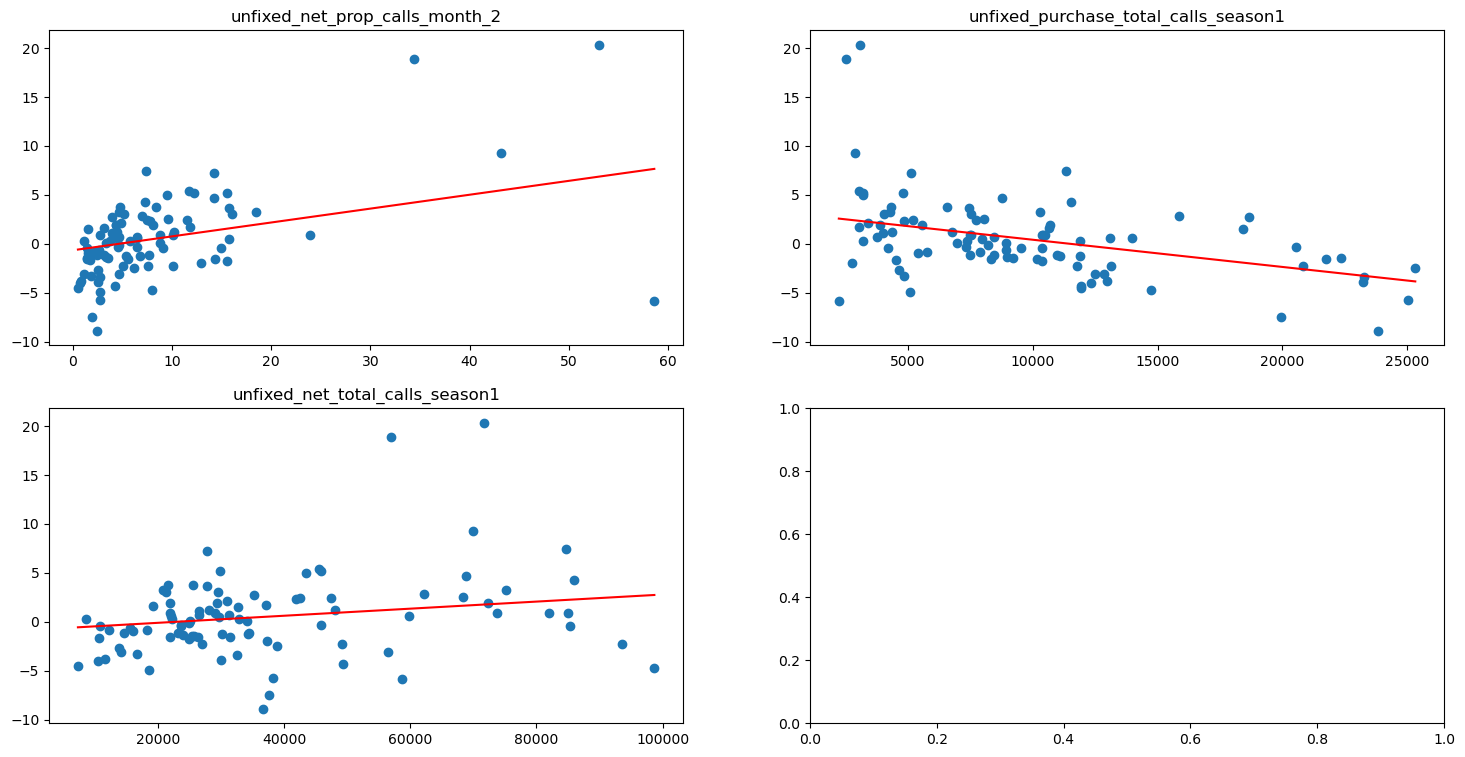

In [445]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, explained_variance_score

class LinearRegressionModel():
    
    def __init__(self, df, month=None):
        
        self.df = df
        self.month = month
        
        if self.month is not None:
            self.df = self.df[self.df['report_month'] == self.month].copy()
    
    def data_prep(self, df, features, outcome):

        df = df[features + [outcome]].dropna()
        
        return df
    #     if len(feat) > 1:

    #     else:
    #         n_missing = df[feat].isnull().sum().sum()
    #         if n_missing > 0:
    #             print(f'Warning: dropping {n_missing} missing values from feature')
    #             df = df[df[feat].notnull()].copy()

    #     n_y_missing = df[outcome].isnull().sum()
    #     if n_y_missing > 0:
    #         print(f'Warning: dropping {n_y_missing} missing values from outcome')
    #         df = df[df[outcome].notnull()].copy()
    
    def fit(self, features, outcome):
        
        if isinstance(features, str):
            features = [features]
            
        self.features = features
        self.outcome = outcome
        
        self.df = self.data_prep(self.df, features, outcome)
        
        self.model = LinearRegression()
        self.model.fit(self.df[features], self.df[outcome])

        self.df['pred'] = self.model.predict(self.df[features])

        # self.explained_variance = explained_variance_score(self.df[outcome], self.model.predict(self.df[features]))
    
    def plot(self, n_per_row=2, figsize=(18, 9)):
        
        n_feats = len(self.features)
        n_rows = math.ceil(n_feats / n_per_row)

        _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)

        if n_feats > 1:
            axes = axs.flatten()
        else:
            axes = [axs]

        for feat, ax in zip(self.features, axes):

            other_features = [x for x in self.features if x != feat]
            df_preds = pd.DataFrame({feat:np.arange(self.df[feat].min(), self.df[feat].max(), 0.01)})

            for constant_feat in other_features:
                df_preds[constant_feat] = self.df[constant_feat].mean()

            df_preds['pred'] = self.model.predict(df_preds[self.features])

            ax.scatter(self.df[feat], self.df[self.outcome])
            ax.plot(df_preds[feat], df_preds['pred'], c='red')
            ax.set_title(f'{feat}')

model = LinearRegressionModel(df_mset, 2)
model.fit(features=['unfixed_net_prop_calls_month_2', 
                    'unfixed_purchase_total_calls_season1', 
                    'unfixed_net_total_calls_season1'], 
          outcome='value_delta_mean_30_forward')
model.plot()

In [378]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, explained_variance_score

def univariate_model(df, month, features, outcome, n_per_row=2, figsize=(18, 9)):
    
    df = df_mset[df_mset.report_month == month].copy()
    
    if isinstance(features, str):
        features = [features]
        
    df = df[features + [outcome]].dropna()
#     if len(feat) > 1:
        
#     else:
#         n_missing = df[feat].isnull().sum().sum()
#         if n_missing > 0:
#             print(f'Warning: dropping {n_missing} missing values from feature')
#             df = df[df[feat].notnull()].copy()
    
#     n_y_missing = df[outcome].isnull().sum()
#     if n_y_missing > 0:
#         print(f'Warning: dropping {n_y_missing} missing values from outcome')
#         df = df[df[outcome].notnull()].copy()
        
    model = LinearRegression()
    model.fit(df[features], df[outcome])

    df['pred'] = model.predict(df[features])

    explained_variance = explained_variance_score(df[outcome], model.predict(df[features]))
    
    n_feats = len(features)
    n_rows = math.ceil(n_feats / n_per_row)
    
    _, axs = plt.subplots(n_rows, n_per_row, figsize=figsize)
    
    if n_feats > 1:
        axes = axs.flatten()
    else:
        axes = [axs]
        
    for feat, ax in zip(features, axes):
        
        other_features = [x for x in features if x != feat]
        df_preds = pd.DataFrame({feat:np.arange(df[feat].min(), df[feat].max(), 0.01)})
        
        for constant_feat in other_features:
            df_preds[constant_feat] = df[constant_feat].mean()
        
        df_preds['pred'] = model.predict(df_preds[features])

        ax.scatter(df[feat], df[outcome])
        ax.plot(df_preds[feat], df_preds['pred'], c='red')
        ax.set_title(f'{feat}, Explained Variance: {np.round(explained_variance, 2)}')

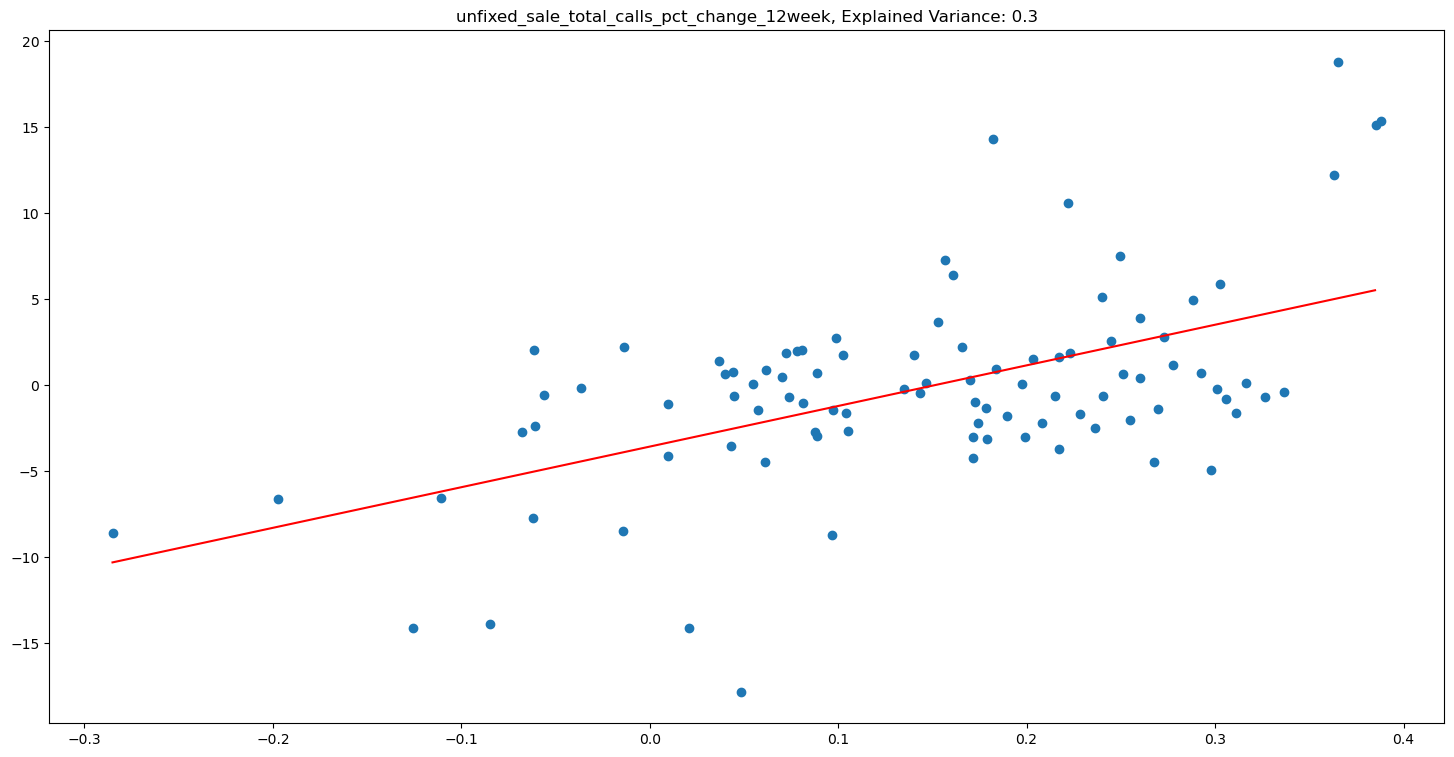

In [368]:
univariate_model(df, 9, features='unfixed_sale_total_calls_pct_change_12week', outcome='value_delta_mean_30_forward')

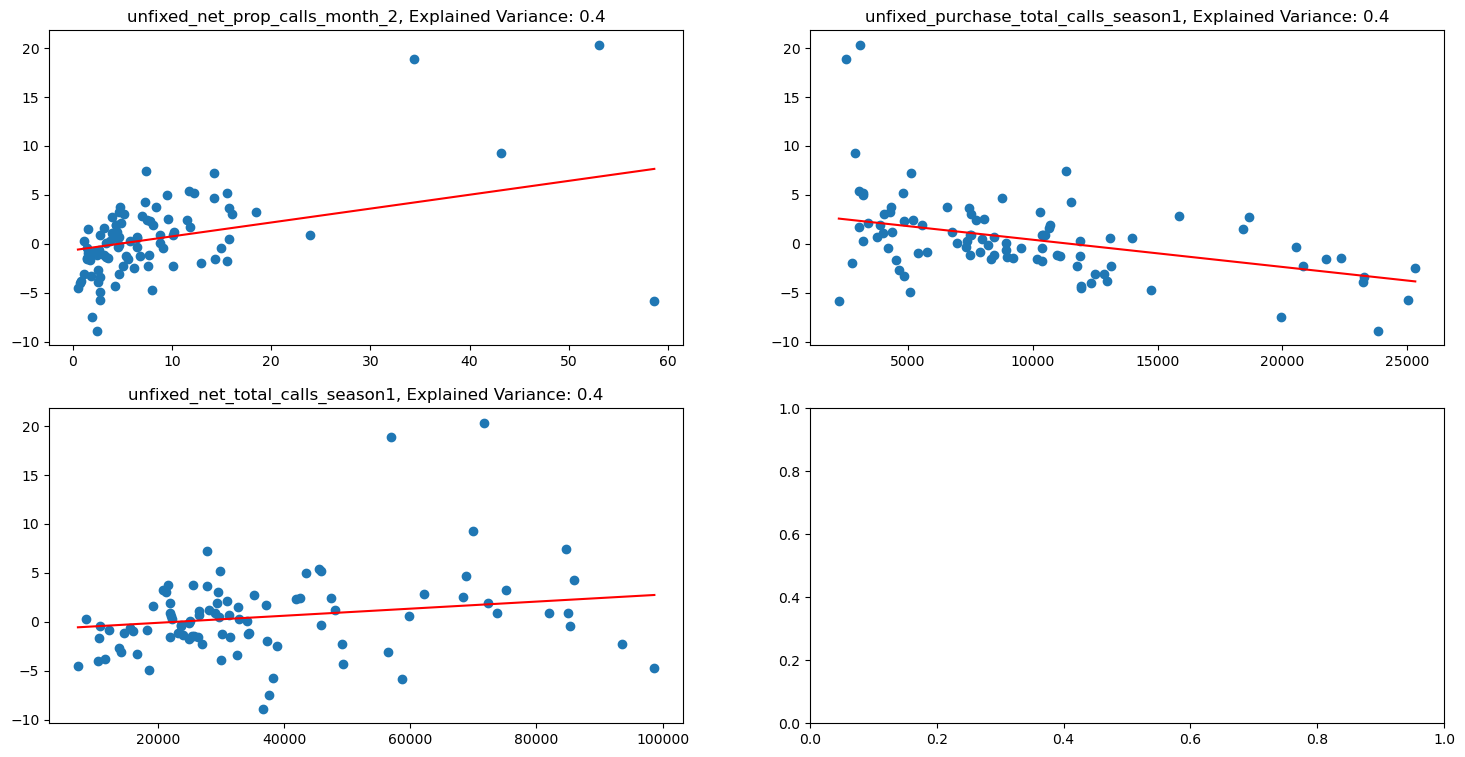

In [379]:
univariate_model(df, 2, 
                 features=['unfixed_net_prop_calls_month_2', 'unfixed_purchase_total_calls_season1', 'unfixed_net_total_calls_season1'], 
                 outcome='value_delta_mean_30_forward')

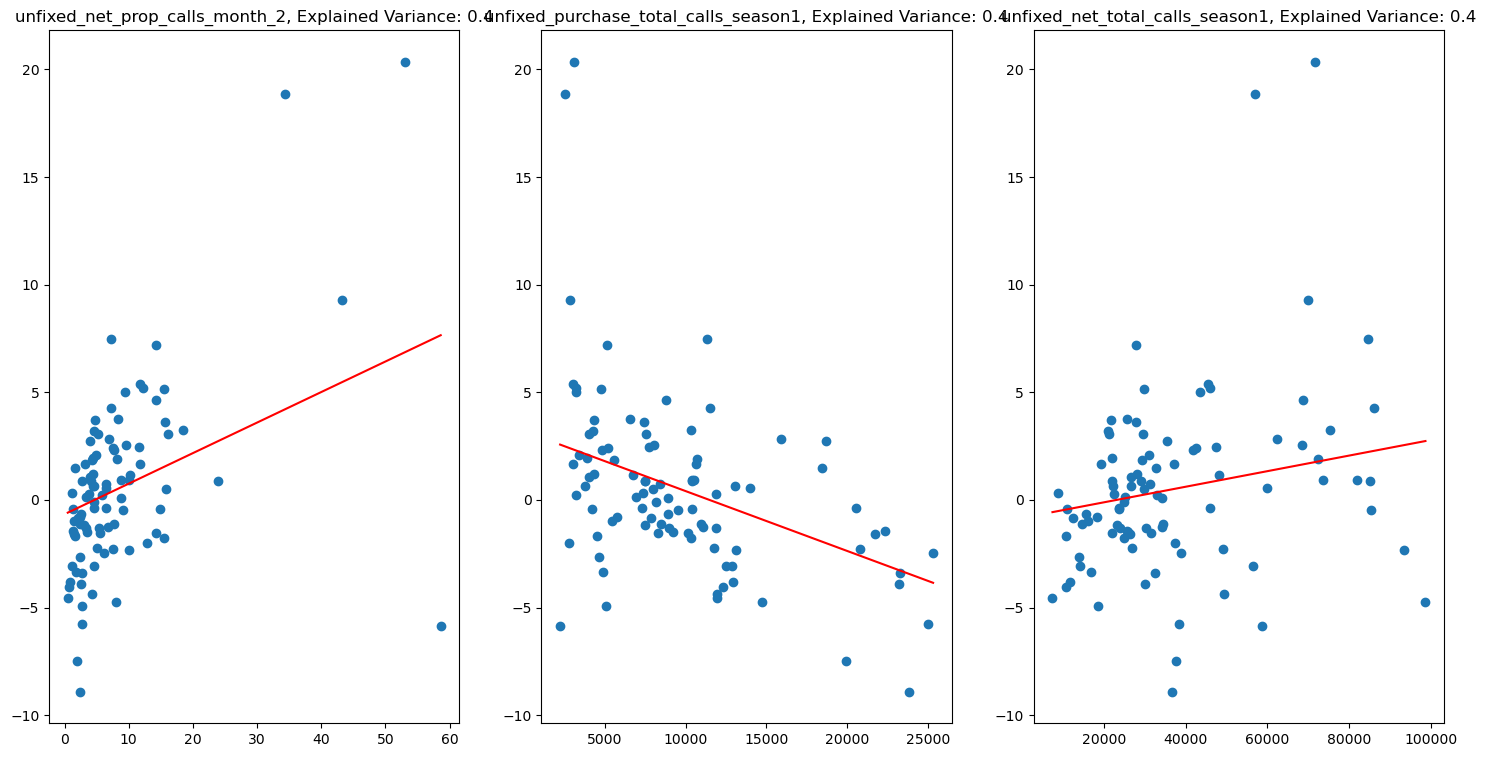

In [357]:
univariate_model(df, 2, 
                 features=['unfixed_net_prop_calls_month_2', 'unfixed_purchase_total_calls_season1', 'unfixed_net_total_calls_season1'], 
                 outcome='value_delta_mean_30_forward')

array([[<Axes: title={'center': 'value_delta_mean_30_forward'}>]],
      dtype=object)

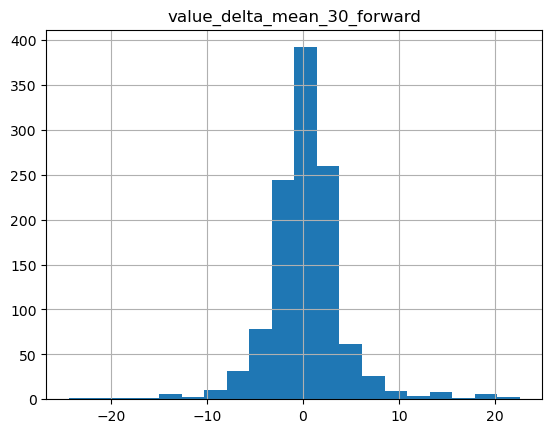

In [292]:
df_mset[(df_mset[outcome]>-25) & (df_mset[outcome]<25)].hist(outcome, bins=20)

In [302]:
def define_traffic_light_bounds(df, bounds):
    
    query = "df['traffic_light'] = "
    
    for i, boundary in enumerate(bounds):
        query = query + f"np.where(df['pred'] < {boundary}, {i}, \n"
    
    query = query + f"{i+1}{(i+1)*')'}"
    
    print(query)
    
    exec(query)
    
define_traffic_light_bounds(df, [-8, -5, 0, 5, 8])

df['traffic_light'] = np.where(df['pred'] < -8, 0, 
np.where(df['pred'] < -5, 1, 
np.where(df['pred'] < 0, 2, 
np.where(df['pred'] < 5, 3, 
np.where(df['pred'] < 8, 4, 
5)))))


In [303]:
df['traffic_light'].value_counts().sort_values()

0     2
4     4
1     7
2    36
3    47
Name: traffic_light, dtype: int64

In [300]:
df['traffic_light'].value_counts().sort_values()

0     1
4     4
1     8
2    36
3    47
Name: traffic_light, dtype: int64

array([[<Axes: title={'center': 'pred'}>]], dtype=object)

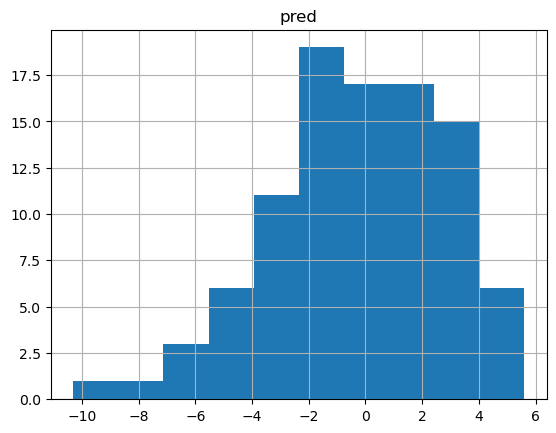

In [287]:
df.hist('pred')

In [248]:
outcome = 'value_delta_mean_30_forward'
correlation_vars = feat_vars + [outcome]

df_corr = df_mset[correlation_vars].corr().reset_index().rename(columns={'index':'feat'})
df_corr[df_corr.feat != outcome][[outcome]].sort_values(outcome)

,value_delta_mean_30_forward
187,-0.170384
194,-0.159619
188,-0.126528
104,-0.120598
38,-0.112639
...,...
76,0.145933
75,0.168959
191,0.177965
178,0.218930


In [223]:
df_monthly_corrs = pd.concat(correlations)
df_monthly_corrs.sort_values('value_delta_mean_30_forward')

,feat,value_delta_mean_30_forward,null_prop,report_month
0,unfixed_net_prop_total_calls_pct_change_4week,-0.722734,0.777778,11
0,unfixed_net_prop_total_calls_pct_change_12week,-0.590039,0.700935,3
0,unfixed_net_prop_calls_month_6_pct_change_2week,-0.537697,0.098039,7
0,unfixed_purchase_calls_month_1_pct_change_8week,-0.521684,0.520833,9
1,unfixed_purchase_calls_month_1_pct_change_4week,-0.517773,0.500000,9
...,...,...,...,...
4,unfixed_net_prop_calls_month_2,0.705550,0.000000,1
4,unfixed_net_prop_total_calls_season1,0.744451,0.000000,10
5,unfixed_net_prop_total_calls,0.760458,0.421569,8
5,unfixed_net_prop_calls_month_1,0.792102,0.000000,1


In [210]:
df = df_mset[df_mset.report_month==9]
df.isnull().sum().sort_values()

date                                                      0
unfixed_purchase_total_calls_season2_pct_change_1week     0
unfixed_purchase_total_calls_season2_pct_change_2week     0
unfixed_purchase_total_calls_season2_pct_change_4week     0
unfixed_purchase_total_calls_season2_pct_change_8week     0
                                                         ..
unfixed_purchase_calls_month_1_pct_change_4week          48
unfixed_net_calls_month_1_pct_change_1week               48
unfixed_purchase_calls_month_1_pct_change_2week          49
unfixed_purchase_calls_month_1_pct_change_8week          50
unfixed_purchase_calls_month_1_pct_change_1week          52
Length: 179, dtype: int64

<Axes: xlabel='unfixed_net_prop_calls_month_2', ylabel='value_delta_mean_30_forward'>

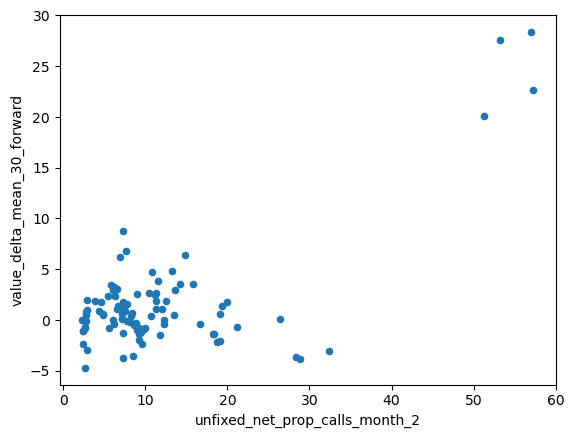

In [227]:
df_mset[df_mset.report_month==1].plot(kind='scatter', x='unfixed_net_prop_calls_month_2', y='value_delta_mean_30_forward')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='unfixed_net_prop_total_calls', ylabel='value_delta_mean_30_forward'>

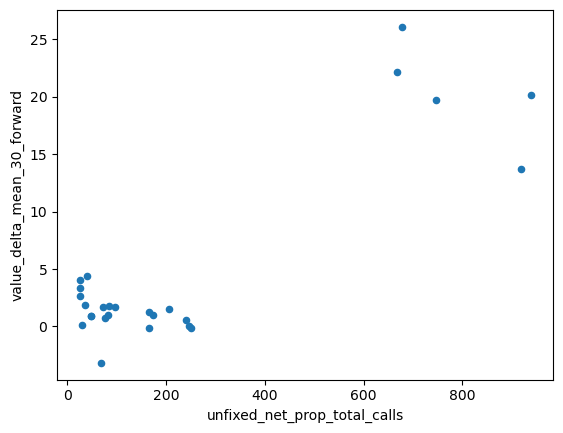

In [217]:
df_mset[df_mset.report_month==10].plot(kind='scatter', x='unfixed_net_prop_total_calls', y='value_delta_mean_30_forward')

<Axes: xlabel='unfixed_sale_total_calls_pct_change_12week', ylabel='value_delta_mean_30_forward'>

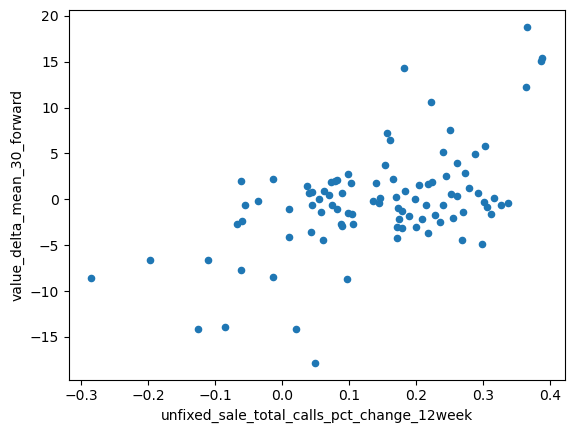

In [207]:
df_mset[df_mset.report_month==9].plot(kind='scatter', x='unfixed_sale_total_calls_pct_change_12week', y='value_delta_mean_30_forward')

In [96]:
df_binary

,month,feature,corr,pvalue
0,2,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
1,3,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
2,4,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
3,5,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
4,6,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
5,7,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
6,8,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
7,9,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
8,10,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875
9,11,unfixed_purchase_calls_month_2_pct_change_4week,0.072163,0.016875


<Axes: xlabel='unfixed_purchase_calls_month_2', ylabel='pct_delta_mean_30_forward'>

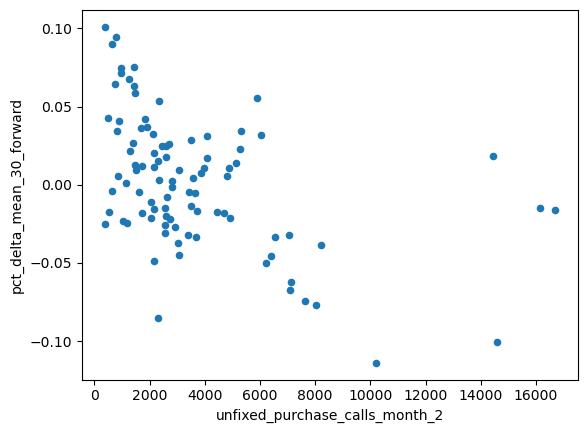

In [59]:
prep.df_mset[prep.df_mset.report_month == 2].plot(x='unfixed_purchase_calls_month_2', y='pct_delta_mean_30_forward', kind='scatter')

/Users/thomaspile/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='unfixed_purchase_calls_month_2', ylabel='pct_delta_mean_30_forward'>

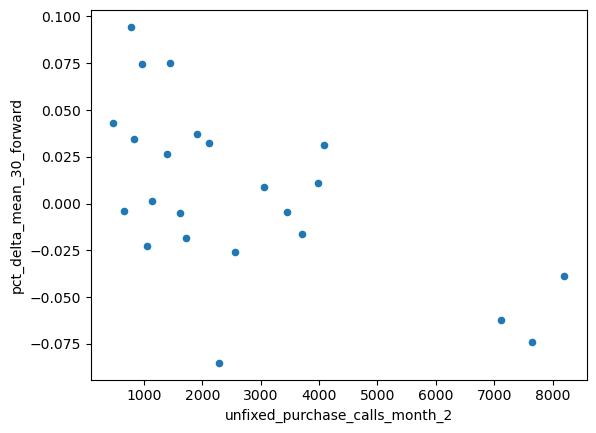

In [122]:
prep.df_mset[prep.df_mset.report_week == 6].plot(x='unfixed_purchase_calls_month_2', y='pct_delta_mean_30_forward', kind='scatter')